In [1]:
# mike babb
# 2024 06 28
# what streets start and stop?

In [2]:
# standard
import os

In [51]:
# external
from itertools import combinations, product
import geopandas as gpd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import LineString, Point
from shapely import line_merge

In [52]:
# custom
from geodataio.geo_operations import points2distance, calculate_initial_compass_bearing
from utils import *

# load the street network

In [5]:
# file path
input_file_path = 'H:/project/seattle_streets/data/' 
output_file_path = 'H:/project/seattle_streets/data/individual_streets'

In [6]:
file_name = 'Street_Network_Database_Seattle_working.gpkg'

In [7]:
fpn = os.path.join(input_file_path, file_name)

In [8]:
gdf = gpd.read_file(filename = fpn)

In [9]:
gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacod', 'citycode',
       'stname_id', 'st_code', 'arterial_c', 'segment_ty', 'agency_cod',
       'access_cod', 'divided_co', 'structure_', 'legalloc_c', 'vehicle_us',
       'gis_seg_length', 'l_adrs_from', 'l_adrs_to', 'r_adrs_from',
       'r_adrs_to', 'ord_pre_dir', 'ord_street', 'ord_street_type',
       'ord_suf_dir', 'ord_stname', 'l_city', 'l_state', 'l_zip', 'r_city',
       'r_state', 'r_zip', 'sndseg_upd', 'compkey', 'comptype', 'unitid',
       'unitid2', 'city_portion', 'ord_st_type', 'ord_street_st_type',
       'snd_group', 'geometry'],
      dtype='object')

# load the node data

In [10]:
input_file_name = 'Street_Network_Nodes.gpkg'

In [11]:
fpn = os.path.join(input_file_path, input_file_name)

In [12]:
node_gdf = gpd.read_file(filename = fpn)

In [13]:
node_gdf.head()

,node_id,geometry
0,13827,POINT (-122.40808 47.57771)
1,8721,POINT (-122.33029 47.65195)
2,3606,POINT (-122.28808 47.70834)
3,3784,POINT (-122.27712 47.70534)
4,14373,POINT (-122.40387 47.57132)


In [14]:
node_gdf['coords'] = node_gdf['geometry'].map(lambda x: x.coords[0])

In [15]:
node_gdf.head()

,node_id,geometry,coords
0,13827,POINT (-122.40808 47.57771),"(-122.40807905399998, 47.577706970000065)"
1,8721,POINT (-122.33029 47.65195),"(-122.33029050099998, 47.651945700000056)"
2,3606,POINT (-122.28808 47.70834),"(-122.28808025199999, 47.70834198600005)"
3,3784,POINT (-122.27712 47.70534),"(-122.27712366699996, 47.70533646400003)"
4,14373,POINT (-122.40387 47.57132),"(-122.40386783599996, 47.57132209200006)"


In [16]:
# zap this into a dictionary
node_dict = {}
for my_row in node_gdf.itertuples():
    node_dict[my_row.node_id] = my_row.coords

# COUNT UNIQUE STREET GROUPS

In [17]:
gdf_agg = gdf[['ord_stname', 'ord_st_type', 'snd_group']].drop_duplicates().groupby(['ord_stname', 'ord_st_type']).agg( snd_group_count = ('snd_group', 'size')).reset_index()

In [18]:
gdf_agg.shape

(2510, 3)

In [19]:
gdf_agg.head()

,ord_stname,ord_st_type,snd_group_count
0,10TH AVE,AVE,4
1,10TH AVE E,AVE,4
2,10TH AVE NE,AVE,2
3,10TH AVE NW,AVE,5
4,10TH AVE S,AVE,8


In [20]:
gdf_agg['snd_group_count'].describe()

count    2510.000000
mean        2.443028
std         2.353508
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: snd_group_count, dtype: float64

In [21]:
# number of streets with at least two segments
gdf_agg.loc[gdf_agg['snd_group_count'] > 1, :].shape

(1131, 3)

In [22]:
# percent
1131 / gdf_agg.shape[0]

0.450597609561753

In [23]:
gdf_agg.loc[gdf_agg['snd_group_count'] == 1, :].shape

(1379, 3)

In [24]:
# percent
1379 / gdf_agg.shape[0]

0.549402390438247

In [25]:
# 55 percent of streets are single segment
# 45 percent of streets are multi-segments.
# TODO: figure out how much of this is road miles.

In [26]:
# IDENTIFY THE STREET SUFFIX TYPE - IF NOT ALREADY DONE.

In [27]:
gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacod', 'citycode',
       'stname_id', 'st_code', 'arterial_c', 'segment_ty', 'agency_cod',
       'access_cod', 'divided_co', 'structure_', 'legalloc_c', 'vehicle_us',
       'gis_seg_length', 'l_adrs_from', 'l_adrs_to', 'r_adrs_from',
       'r_adrs_to', 'ord_pre_dir', 'ord_street', 'ord_street_type',
       'ord_suf_dir', 'ord_stname', 'l_city', 'l_state', 'l_zip', 'r_city',
       'r_state', 'r_zip', 'sndseg_upd', 'compkey', 'comptype', 'unitid',
       'unitid2', 'city_portion', 'ord_st_type', 'ord_street_st_type',
       'snd_group', 'geometry'],
      dtype='object')

In [28]:
gdf['ord_st_type'].isna().unique()

array([False])

# FIND MISSING SEGMENTS

In [29]:
# create a weight variable from the gis_segment_length variable
gdf['weight'] = gdf['gis_seg_length']

In [30]:
gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacod', 'citycode',
       'stname_id', 'st_code', 'arterial_c', 'segment_ty', 'agency_cod',
       'access_cod', 'divided_co', 'structure_', 'legalloc_c', 'vehicle_us',
       'gis_seg_length', 'l_adrs_from', 'l_adrs_to', 'r_adrs_from',
       'r_adrs_to', 'ord_pre_dir', 'ord_street', 'ord_street_type',
       'ord_suf_dir', 'ord_stname', 'l_city', 'l_state', 'l_zip', 'r_city',
       'r_state', 'r_zip', 'sndseg_upd', 'compkey', 'comptype', 'unitid',
       'unitid2', 'city_portion', 'ord_st_type', 'ord_street_st_type',
       'snd_group', 'geometry', 'weight'],
      dtype='object')

In [31]:
# the get the list of unique names
s_name = gdf_agg['ord_stname'].unique().tolist()

In [32]:
# let's create another dictionary with the st name and the street type;

In [33]:
st_name_type_dict = {st_name:st_type for st_name, st_type in zip(gdf_agg['ord_stname'], gdf_agg['ord_st_type'])}

In [34]:
gdf_agg['ord_st_type'].unique()

array(['AVE', 'PL', 'RD', 'CT', 'BR', 'WKWY', 'LN', 'TER', 'ST', 'CIR',
       'WAY', 'VI', 'DR', 'BLVD', 'PKWY', 'MALL', 'PZ', 'VIEW', 'LOOP'],
      dtype=object)

In [35]:
write_intermediate = False
did_it_work = False
output_gdf_list = []


for sn in s_name[:None]:
    print(sn)
    # subset the gdf by streetname
    temp_gdf = gdf.loc[gdf['ord_stname'] == sn, :].copy()

    if write_intermediate:
        output_file_name = '_'.join(sn.split()) + '.gpkg'
        write_gdf(gdf = temp_gdf, output_file_path = output_file_path, output_file_name = output_file_name)

    # create the graph for a single street network
    fg = nx.from_pandas_edgelist(df = temp_gdf, source = 'f_intr_id', target = 't_intr_id', edge_attr=True)
    node_list = list(fg.nodes)

    # a list of the snd groups - this is necessary to 
    # match street segments to nodes
    snd_group_id_list = temp_gdf['snd_group'].unique()
    
    # full nodes - all nodes in the line segments.
    if write_intermediate:
        curr_node_df = pd.DataFrame(data = {'node_id':fg.nodes()})
        curr_node_list = curr_node_df['node_id'].tolist()
        node_subset_gdf = subset_node_gdf(node_gdf = node_gdf, other_node_df = curr_node_df)
        output_file_name = 'full_nodes_' + '_'.join(sn.split()) + '.gpkg'
        write_gdf(gdf = node_subset_gdf, output_file_path = output_file_path, output_file_name = output_file_name)

    
    # for now, only the streets with two or more segments
    if len(snd_group_id_list) > 1:
        node_snd_group_dict = {}
        # a node - an intersection - can have one more streets.
        # we need to update the node snd group dict every time
        for myrow in temp_gdf.itertuples():       
            fn = myrow.f_intr_id
            tn = myrow.t_intr_id
            snd_group_id = myrow.snd_group
            node_snd_group_dict[fn] = snd_group_id
            node_snd_group_dict[tn] = snd_group_id                                             
        
        # step create a list of available edges - these are the missing segments
        # these are formed from the non-edges of the graph.
        # list to hold available edges
        avail_edges = []
        # dictionary to hold available edges
        # let's only make the distance calculation once, yeah?
        # it's a simple calculate, but even more simple to store it. 
        node_dist_dict = {}
        for ne in nx.non_edges(fg):    
            # ne is a tuple of from / to nodes.
            # create available edges if the nodes are not on the same segment
            # this will decrease the potential solution space
            if node_snd_group_dict[ne[0]] != node_snd_group_dict[ne[1]]:
                # calculate the straight-line distance between two nodes. 
                # convert to feet to match the existing weight
                weight = points2distance(node_dict[ne[0]], node_dict[ne[1]], unit = 'miles') * 5280
                # build the output tuple
                output = (ne[0], ne[1], {'weight':weight})
                # add 
                node_dist_dict[(ne[0], ne[1])] = weight 
                node_dist_dict[(ne[1], ne[0])] = weight 
                avail_edges.append(output)

        # these are missing segments.
        # nx.k_edge_augmentation creates the missing edges in a graph by adding as
        # few edges as possible. In a street network, with multiple disconnected
        # components, there is really one way to minimally connect the disparate components
        # to create full connectivity. And it's the shortest geographic segment in this case!
        # weighted graph traversal works by accumulating as little weight as possible. 
        
        data_list = []
        line_list = []
        # once nx.k_edge_augmentation finishes, it returns a generator with the added edges that
        # ensure complete connectivity.
        augmented_edges = nx.k_edge_augmentation(G = fg, k = 1, avail = avail_edges, weight = 'weight')    
        # so, get at the generator
        for i_ae, ae in enumerate(augmented_edges):
            # unpack
            fn, tn = ae            
            # get the weight of the added edge
            weight = node_dist_dict[(fn, tn)] 
            # this is information about the created str strype
            st_type = st_name_type_dict[sn]
            temp_data_list = [sn, st_type,  i_ae, fn, tn, weight]
            # now, let's create some geometry
            temp_line = LineString([node_dict[fn], node_dict[tn]])
            line_list.append(temp_line)
            data_list.append(temp_data_list)

        # build a gpd.GeoDataFrame - these are the "missing" segments"
        ms_gdf = gpd.GeoDataFrame(data = data_list,
                                         columns = ['ord_stname', 'ord_st_type', 'snd_group', 'sn_id', 'en_id', 'dist'],
                                         geometry = line_list, crs = 'epsg:4326')
        ms_gdf['same_snd_group'] = int(0)

        # now, we need to get the known segments
        col_names = ['ord_stname', 'ord_st_type', 'snd_group',  'f_intr_id', 't_intr_id', 'gis_seg_length', 'geometry']    
        ks_gdf = temp_gdf[col_names].copy()
        ks_gdf['same_snd_group'] = int(1)
        ks_gdf = ks_gdf.rename(columns = {'f_intr_id':'sn_id', 't_intr_id':'en_id', 'gis_seg_length':'dist'})

        # stack the geodataframes
        output_gdf = pd.concat([ms_gdf, ks_gdf])
    
        # write intermediate
        if write_intermediate:
            output_file_name = 'missing_segments_' + '_'.join(sn.split()) + '.gpkg'
            ofpn = os.path.join(output_file_path, output_file_name)                
            output_gdf.to_file(filename = ofpn, driver = 'GPKG', index = False)
       

    else:
        # gather the streets with no missing segments. Solid segments        
        col_names = ['ord_stname', 'ord_st_type', 'snd_group', 'f_intr_id', 't_intr_id', 'gis_seg_length', 'geometry']    
        output_gdf = temp_gdf[col_names].copy()
        output_gdf['same_snd_group'] = int(-1)
        output_gdf = output_gdf.rename(columns = {'f_intr_id':'sn_id', 't_intr_id':'en_id', 'gis_seg_length':'dist'})
        
    output_gdf_list.append(output_gdf)
        
did_it_work = True

10TH AVE
10TH AVE E
10TH AVE NE
10TH AVE NW
10TH AVE S
10TH AVE SW
10TH AVE W
10TH PL NE
10TH PL SW
10TH PL W
11TH AV NW ACCESS RD
11TH AV SW ACCESS RD
11TH AVE
11TH AVE E
11TH AVE NE
11TH AVE NW
11TH AVE S
11TH AVE SW
11TH AVE W
11TH PL NW
12TH AVE
12TH AVE E
12TH AVE NE
12TH AVE NW
12TH AVE S
12TH AVE SW
12TH AVE W
13TH AVE
13TH AVE E
13TH AVE NW
13TH AVE S
13TH AVE SW
13TH AVE W
13TH PL S
14TH AVE
14TH AVE E
14TH AVE NE
14TH AVE NW
14TH AVE S
14TH AVE SW
14TH AVE W
14TH CT S
14TH PL NE
15TH AVE
15TH AVE E
15TH AVE NE
15TH AVE NW
15TH AVE S
15TH AVE SW
15TH AVE W
15TH PL NE
15TH PL S
15TH PL W
16TH AV S BR
16TH AVE
16TH AVE E
16TH AVE NE
16TH AVE NW
16TH AVE S
16TH AVE SW
16TH AVE W
17TH AVE
17TH AVE E
17TH AVE NE
17TH AVE NW
17TH AVE NW WKWY
17TH AVE S
17TH AVE SW
17TH AVE W
17TH PL NE
17TH PL S
18TH AVE
18TH AVE E
18TH AVE NE
18TH AVE NW
18TH AVE S
18TH AVE SW
18TH AVE W
18TH PL NW
19TH AVE
19TH AVE E
19TH AVE NE
19TH AVE NW
19TH AVE S
19TH AVE SW
19TH AVE W
19TH PL S
1ST AV S BR N

C:\Users\babbm\AppData\Local\Temp\ipykernel_26244\4257720660.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_gdf = pd.concat([ms_gdf, ks_gdf])


E DENNY BLAINE PL
E DENNY WAY
E EATON PL
E EDGAR ST
E EDGEWATER PL
E FIR ST
E FLORENCE CT
E FORD PL
E FOSTER ISLAND RD
E GALER ST
E GARFIELD ST
E GLEN ST
E GWINN PL
E HAMLIN ST
E HARRISON ST
E HELEN ST
E HIGH LN
E HIGHLAND DR
E HOWE ST
E HOWELL ST
E HURON ST
E INTERLAKEN BLVD
E JAMES CT
E JAMES ST
E JAMES WAY
E JANSEN CT
E JEFFERSON ST
E JOHN CT
E JOHN ST
E LAKE WASHINGTON BLVD
E LEE ST
E LORETTA PL
E LOUISA ST
E LYNN ST
E MADISON ST
E MARION ST
E MARTIN ST
E MCGILVRA ST
E MCGRAW ST
E MERCER ST
E MILLER ST
E MORLEY WAY
E NELSON PL
E NEWTON ST
E NORTH ST
E OLIN PL
E OLIVE LN
E OLIVE PL
E OLIVE ST
E OLIVE ST WKWY
E OLIVE WAY
E PIKE ST
E PINE ST
E PROSPECT ST
E REMINGTON CT
E REPUBLICAN ST
E ROANOKE ST
E ROY ST
E SAINT ANDREWS WAY
E SCHUBERT PL
E SENECA ST
E SHELBY ST
E SHORE DR
E SPRING ST
E SPRUCE ST
E SUPERIOR ST
E TERRACE ST
E THOMAS ST
E UNION ST
E UNIVERSITY BLVD
E VALLEY ST
E WARD ST
E YESLER WAY
EAGLE ST
EARL AVE NW
EAST FRONTAGE RD S
EAST GREEN LAKE DR N
EAST GREEN LAKE WAY N
EAS

C:\Users\babbm\AppData\Local\Temp\ipykernel_26244\4257720660.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_gdf = pd.concat([ms_gdf, ks_gdf])


MONTAVISTA PL W
MONTLAKE BLVD E
MONTLAKE BLVD NE
MONTLAKE BR
MONTVALE CT W
MONTVALE PL W
MORLEY PL W
MORROW LN
MORSE AVE S
MOUNT ADAMS PL S
MOUNT BAKER DR S
MOUNT CLAIRE DR S
MOUNT RAINIER DR S
MOUNT ST HELENS PL S
MOUNT VIEW DR S
MOUNTAIN DR W
MURRAY AVE SW
MYERS WAY S
N 100TH ST
N 101ST ST
N 102ND ST
N 103RD ST
N 104TH ST
N 105TH ST
N 106TH ST
N 107TH ST
N 109TH ST
N 110TH ST
N 112TH ST
N 113TH PL
N 113TH ST
N 114TH ST
N 115TH ST
N 116TH ST
N 117TH PL
N 117TH ST
N 120TH ST
N 121ST ST
N 122ND PL
N 122ND ST
N 125TH ST
N 127TH ST
N 128TH ST
N 130TH ST
N 131ST ST
N 132ND ST
N 133RD ST
N 134TH ST
N 135TH PL
N 135TH ST
N 136TH ST
N 137TH ST
N 138TH ST
N 140TH ST
N 141ST CT
N 141ST ST
N 142ND ST
N 143RD ST
N 144TH ST
N 145TH ST
N 34TH ST
N 35TH ST
N 36TH ST
N 37TH ST
N 38TH CT
N 38TH ST
N 39TH ST
N 40TH ST
N 41ST ST
N 42ND ST
N 43RD ST
N 44TH ST
N 45TH ST
N 46TH ST
N 47TH ST
N 48TH ST
N 49TH ST
N 50TH ST
N 51ST ST
N 52ND ST
N 53RD ST
N 54TH ST
N 55TH ST
N 56TH ST
N 57TH ST
N 58TH ST
N 59TH 

C:\Users\babbm\AppData\Local\Temp\ipykernel_26244\4257720660.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_gdf = pd.concat([ms_gdf, ks_gdf])


NE SAN JUAN RD
NE SKAGIT LN
NE SNOHOMISH LN
NE STEVENS WAY
NE SUNRISE VISTA
NE SURBER DR
NE THORNTON PL
NE THURSTON LN
NE TULANE PL
NE UNIVERSITY VILLAGE ST
NE URBAN VISTA
NE VILLAGE LN
NE WAHKIAKUM LN
NE WALLA WALLA RD
NE WHITMAN LN
NE WINDERMERE RD
NEBRASKA ST
NESBIT AVE N
NEWELL ST
NEWPORT WAY
NEWTON ST
NICKERSON ST
NICKERSON TURN RD
NICKLAS PL NE
NOB HILL AVE N
NOB HILL PL N
NORTH KC AIRPORT ACC RD
NORTH PARK AVE N
NORTHEAST NORTHGATE DR E
NORTHEAST NORTHGATE DR W
NORTHGATE MALL
NORTHGATE PZ
NORTHROP PL SW
NORTHSHIRE RD NW
NORTHWOOD PL NW
NORTHWOOD RD NW
NORWOOD PL
NP RR BR
NW 100TH PL
NW 100TH ST
NW 101ST ST
NW 103RD ST
NW 104TH ST
NW 105TH ST
NW 106TH ST
NW 107TH ST
NW 108TH ST
NW 110TH ST
NW 112TH ST
NW 113TH PL
NW 113TH ST
NW 114TH PL
NW 114TH ST
NW 115TH ST
NW 116TH ST
NW 117TH ST
NW 118TH ST
NW 119TH ST
NW 120TH ST
NW 121ST ST
NW 122ND ST
NW 125TH ST
NW 126TH PL
NW 126TH ST
NW 127TH ST
NW 130TH ST
NW 131ST ST
NW 132ND ST
NW 134TH ST
NW 135TH PL
NW 136TH ST
NW 137TH PL
NW 137T

C:\Users\babbm\AppData\Local\Temp\ipykernel_26244\4257720660.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_gdf = pd.concat([ms_gdf, ks_gdf])


SOUND VIEW TER W
SPEAR PL S
SPOKANE LN NE
SPOKANE TURN RD
SPORTSFIELD DR NE
SPRING ST
SPRUCE ST
STADIUM PL S
STANFORD AVE NE
STANLEY AVE S
STANTON PL NW
STATION 30 ACCESS RD
STENDALL DR N
STENDALL PL N
STEWART ST
STONE AVE N
STONE WAY N
STROUD AVE N
STURGUS AVE S
STURTEVANT AVE S
SUMMIT AVE
SUMMIT AVE E
SUMNER AVE SW
SUNNYSIDE AVE N
SUNSET AVE SW
SURBER DR NE
SW 100TH ST
SW 101ST ST
SW 102ND LN
SW 102ND ST
SW 103RD PL
SW 103RD ST
SW 104TH ST
SW 105TH PL
SW 105TH ST
SW 106TH ST
SW 107TH PL
SW 107TH ST
SW 107TH WAY
SW 108TH PL
SW 108TH ST
SW 109TH ST
SW 110TH LN
SW 110TH PL
SW 110TH ST
SW 111TH LN
SW 111TH PL
SW 111TH ST
SW 112TH LN
SW 112TH PL
SW 112TH ST
SW 113TH LN
SW 113TH ST
SW 114TH ST
SW 115TH ST
SW 116TH ST
SW 96TH CIR
SW 96TH LN
SW 96TH PL
SW 97TH CT
SW 97TH PL
SW 97TH ST
SW 98TH ST
SW 98TH ST WKWY
SW 99TH PL
SW 99TH ST
SW ADAMS ST
SW ADMIRAL WAY
SW ALASKA ST
SW ANDOVER ST
SW ANDOVER ST PED BR
SW ANGELINE ST
SW ARROYO CT
SW ARROYO DR
SW ATLANTIC ST
SW AUSTIN PL
SW AUSTIN ST
SW A

C:\Users\babbm\AppData\Local\Temp\ipykernel_26244\4257720660.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_gdf = pd.concat([ms_gdf, ks_gdf])


W MANOR PL
W MANSELL ST
W MARGINAL TURN RD
W MARINA PARKING PL
W MARINA PL
W MCCORD PL
W MCGRAW PL
W MCGRAW ST
W MCLAREN ST
W MERCER PL
W MERCER ST
W MONTFORT PL
W NEWELL PL
W NEWELL ST
W NEWTON ST
W NICKERSON ST
W OHMAN PL
W OLYMPIC PL
W OLYMPIC SR PL
W PARKMONT PL
W PLEASANT PL
W PLYMOUTH ST
W PROSPECT ST
W PROSPER ST
W QUEEN ANNE DRIVEWAY
W RAYE ST
W REPUBLICAN ST
W ROBERTS WAY
W ROY ST
W RUFFNER ST
W SEATTLE STADIUM AC RD
W SEMPLE ST
W SHERIDAN ST
W SMITH ST
W THOMAS ST
W THOMAS ST OVERPASS
W THURMAN ST
W TILDEN ST
W VIEW PL
W WHEELER ST
WABASH AVE S
WALL ST
WALLA WALLA RD NE
WALLINGFORD AVE N
WALNUT AVE SW
WARD PL
WARD ST
WARREN AVE N
WARREN PL
WARREN PL N
WASHINGTON AVE
WASHINGTON AVE W
WASHINGTON PL E
WATERS AVE S
WAVERLY PL N
WAVERLY WAY E
WAYNE PL N
WEBSTER POINT RD NE
WEEDIN PL NE
WELLER ST WALKWAY
WELLESLEY WAY NE
WELLINGTON AVE
WEST GREEN LAKE DR N
WEST GREEN LAKE WAY N
WEST LAUREL DR NE
WEST LAURELHURST DR NE
WEST MARGINAL PL S
WEST MARGINAL WAY S
WEST MARGINAL WAY SW
WEST

In [36]:
ms_gdf = pd.concat(objs = output_gdf_list)

In [37]:
ms_gdf['dist_miles'] = ms_gdf['dist'] / 5280

output_file_path = 'H:/project/seattle_streets/data'
output_file_name = 'missing_segments.gpkg'
ofpn = os.path.join(output_file_path, output_file_name)    

ms_gdf.to_file(filename = ofpn, driver = 'GPKG', index = False)

did_it_work

True

In [38]:
ms_gdf.shape

(30336, 9)

In [39]:
ms_gdf.head()

,ord_stname,ord_st_type,snd_group,sn_id,en_id,dist,geometry,same_snd_group,dist_miles
0,10TH AVE,AVE,0,12359,12339,135.408451,"LINESTRING (-122.31941 47.6031, -122.31934 47....",0,0.025646
1,10TH AVE,AVE,1,12162,11978,1104.943768,"LINESTRING (-122.31942 47.60621, -122.31937 47...",0,0.209270
2,10TH AVE,AVE,2,11906,11829,493.739007,"LINESTRING (-122.31936 47.6104, -122.31935 47....",0,0.093511
1113,10TH AVE,AVE,2825,12319,12265,306.876327,"LINESTRING (-122.31941 47.60352, -122.31941 47...",1,0.058121
1489,10TH AVE,AVE,2826,11809,11752,278.657501,"LINESTRING (-122.31937 47.61218, -122.31938 47...",1,0.052776


In [40]:
# group by and descibe
wms_gdf = ms_gdf.loc[ms_gdf['same_snd_group'] == 0, :].copy()

In [41]:
wms_gdf.groupby('ord_st_type')['dist_miles'].describe()

,count,mean,std,min,25%,50%,75%,max
ord_st_type,,,,,,,,
AVE,1791.0,0.243821,0.391521,0.002857,0.031881,0.094276,0.256567,3.739595
BLVD,11.0,0.036957,0.033938,0.009122,0.013782,0.030070,0.040803,0.122197
CT,2.0,0.033072,0.020849,0.018329,0.025700,0.033072,0.040443,0.047814
DR,17.0,0.083259,0.093622,0.004334,0.029943,0.057824,0.090285,0.383551
LN,9.0,0.067934,0.128349,0.015234,0.018194,0.023844,0.031653,0.408942
PKWY,1.0,0.015428,NaN,0.015428,0.015428,0.015428,0.015428,0.015428
PL,85.0,0.336505,0.696023,0.007364,0.036732,0.072401,0.318730,4.973674
RD,6.0,0.124215,0.161875,0.017780,0.031751,0.057776,0.124867,0.441649
ST,1658.0,0.214713,0.347929,0.000744,0.035987,0.082830,0.229175,4.048921


In [42]:
# LET'S MAKE A GRAPHIC SHOWING THE DISTRIBUTION OF ADDED STREETS

In [43]:
# find the longest
ms_gdf['same_snd_group'].value_counts()

same_snd_group
 1    21181
-1     5544
 0     3611
Name: count, dtype: int64

In [44]:
gdf['ord_stname'].unique().shape

(2510,)

# LONGEST MISSING STREETS

In [45]:
wms_gdf['dist_rank'] = wms_gdf['dist'].rank(method = 'dense', ascending = False)

In [46]:
wms_gdf.loc[wms_gdf['dist_rank'] <= 10, 'ord_stname'].tolist()

['11TH AVE S',
 '20TH AVE S',
 '33RD AVE SW',
 '7TH PL S',
 '9TH AVE S',
 'S 105TH ST',
 'S 106TH ST',
 'S 108TH ST',
 'S 112TH ST',
 'S 116TH ST']

In [47]:
wms_gdf['dist_miles_log'] = np.log10(wms_gdf['dist_miles'])

In [48]:
wms_gdf['dist_miles_log'].describe()

count    3611.000000
mean       -1.022903
std         0.578679
min        -3.128414
25%        -1.482208
50%        -1.072284
75%        -0.601465
max         0.696677
Name: dist_miles_log, dtype: float64

In [49]:
my_start_list = [100, 250, 500]

for ii in range(1, 5):
    my_calc = int((5280 * (ii / 4)))    
    my_start_list.append(my_calc)    

my_start_list

for ii in range(1, 2):
    for jj in range(0, 5):
        my_calc = int((5280 * (ii / 1)) + (5280 * jj))        
        my_start_list.append(my_calc)    

x_tick_list = [x for x in my_start_list]

In [55]:
x_tick_list

[100, 250, 500, 1320, 2640, 3960, 5280, 5280, 10560, 15840, 21120, 26400]

..\assets\dist_histogram.png


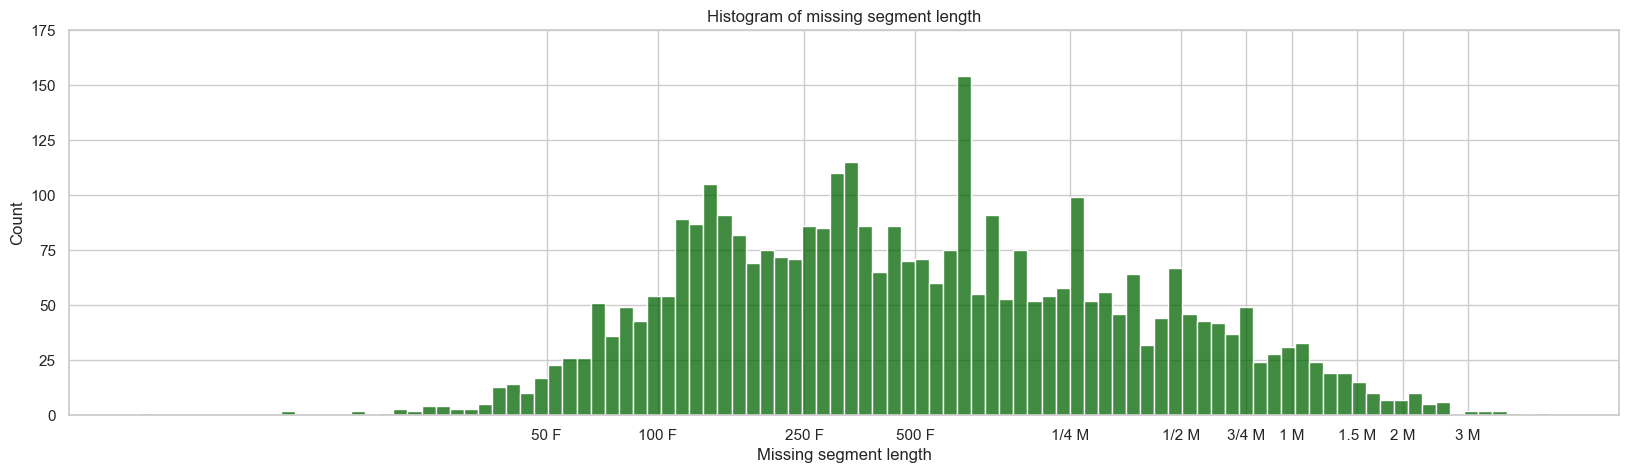

In [71]:
# let's make a graphic showing the distances
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

my_plot = sns.histplot(data = wms_gdf, x = 'dist_miles_log',
                      color='darkgreen', bins = 100)

y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

plt.title(label = "Histogram of missing segment length")
plt.xlabel(xlabel = 'Missing segment length')
plt.ylabel(ylabel = "Count")

x_tick_labels = [50 / 5280, 100 / 5280, 250 / 5280, 500 / 5280, .25, .5, .75, 1, 1.5, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

x_tick_label_text = ['50 F', '100 F', '250 F',  '500 F', '1/4 M', '1/2 M', '3/4 M', '1 M', '1.5 M', '2 M', '3 M']
#x_ticks = [-3, -2, -1, 0, .5]
#x_tick_labels = [10**xt for xt in x_ticks]
#x_tick_labels_formatted = ['{:,}'.format(10**xtl) for xtl in x_ticks]   

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

output_file_name = '..\\assets\\dist_histogram.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)

In [72]:
temp_wms_gdf = wms_gdf.loc[wms_gdf['ord_st_type'].isin(['AVE', 'ST']), :]

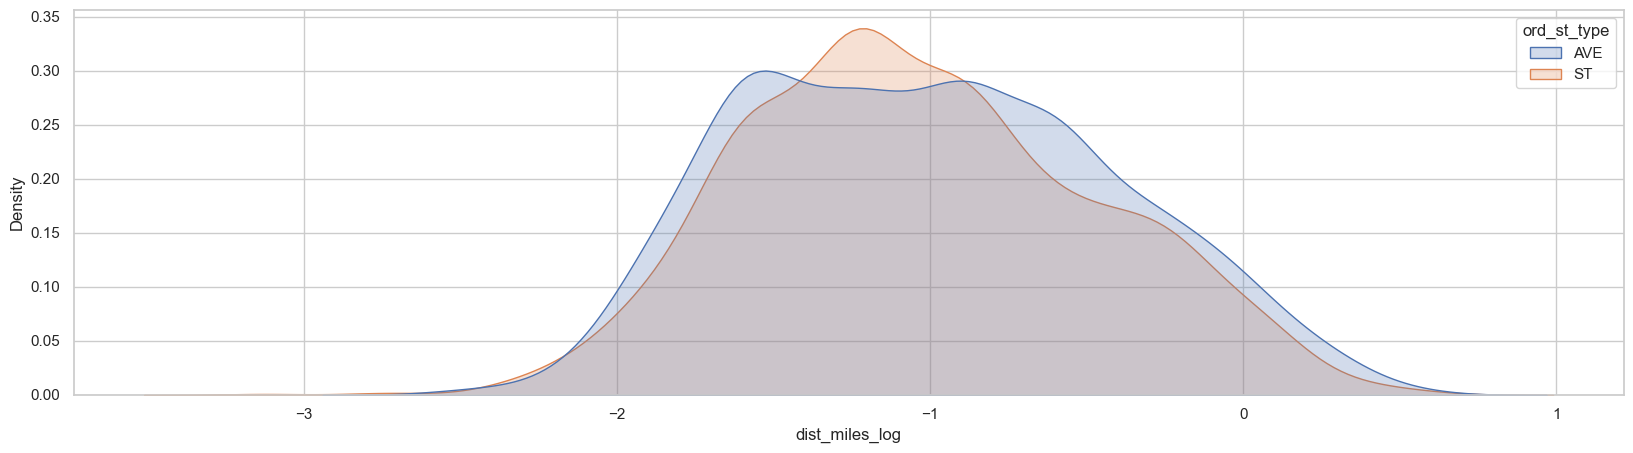

In [77]:
# let's make a graphic showing the distances
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

my_plot = sns.kdeplot(data = temp_wms_gdf, x = 'dist_miles_log', fill = True,
                      hue = 'ord_st_type')

In [91]:
file_name = '../testo.geojson'

In [92]:
tt = temp_wms_gdf.loc[temp_wms_gdf['ord_stname'].str.find('GALER') > 0, :].copy()

In [93]:
tt.to_file(filename = file_name, driver = 'geojson', index = False)

In [ ]:
y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

plt.title(label = "Histogram of missing segment length")
plt.xlabel(xlabel = 'Missing segment length')
plt.ylabel(ylabel = "Count")

x_tick_labels = [50 / 5280, 100 / 5280, 250 / 5280, 500 / 5280, .25, .5, .75, 1, 1.5, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

x_tick_label_text = ['50 F', '100 F', '250 F',  '500 F', '1/4 M', '1/2 M', '3/4 M', '1 M', '1.5 M', '2 M', '3 M']
#x_ticks = [-3, -2, -1, 0, .5]
#x_tick_labels = [10**xt for xt in x_ticks]
#x_tick_labels_formatted = ['{:,}'.format(10**xtl) for xtl in x_ticks]   

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

output_file_name = '..\\assets\\dist_histogram.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)